In [1]:
#%% Imports

import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import OrdinalEncoder
import shapely
from shapely.geometry import Point
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta

import geopandas as gpd
import rioxarray
import rasterio
import xarray as xr
from geocube.api.core import make_geocube

pd.options.mode.chained_assignment = None  # default='warn'
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from io import BytesIO


In [2]:
#%% Definitions

crs_projection = 'epsg:4326'  # Assuming WGS84 coordinate system

# Correct Name for the districts:
districts = pd.read_csv('districts_names.csv')
districts = districts.set_index('AltName').to_dict()['Name']

def correct_districts(df_district):
    return df_district.replace(districts)

regions = {'Banaadir': 'Banadir'}

def correct_regions(df_region):
    return df_region.replace(regions)


#%% SHAPEFILES

Somalia_map_livelihood = gpd.read_file('SO_LHZ_2015.geojson')
Somalia_map_livelihood = Somalia_map_livelihood[['LZNUM', 'LZNAMEEN', 'geometry']].drop(columns={'LZNUM'})

Somalia_map_district = gpd.read_file('Admin2_Map_UNDP.geojson')
Somalia_map_district.admin2Name = correct_districts(Somalia_map_district.admin2Name)
Somalia_map_district = Somalia_map_district.sort_values(['admin2Name']).reset_index(drop=True)

Somalia_map_region = gpd.read_file('Admin1_Map_UNDP.geojson')
Somalia_map_region = Somalia_map_region[['ADM1_EN', 'geometry']]
Somalia_map_region.ADM1_EN = correct_regions(Somalia_map_region.ADM1_EN)


# 1. Climate cubes


In [3]:
#%% Read Climate raster

path_cube = r'C:\Users\chema\OneDrive\Escritorio\Work_to_Do\Somalia\Data Aggregation Final\Climate_data_cubes\UC2_cube_ERA5LAND_2010_2023.nc'

era5 = xr.open_dataset(path_cube)

era5.rio.write_crs(crs_projection, inplace=True)

# Clip to Somalia
UC2_cube = era5.rio.clip(Somalia_map_district.geometry.values, Somalia_map_district.crs)

# Transpose the variables
UC2_cube = UC2_cube.transpose('latitude', 'longitude', 'time')

UC2_cube = UC2_cube.sortby(['latitude', 'longitude','time']) 

UC2_cube


<xarray.Dataset>
Dimensions:      (longitude: 104, latitude: 136, time: 9794)
Coordinates:
  * longitude    (longitude) float32 41.0 41.1 41.2 41.3 ... 51.0 51.1 51.2 51.3
  * latitude     (latitude) float32 -1.6 -1.5 -1.4 -1.3 ... 11.6 11.7 11.8 11.9
  * time         (time) datetime64[ns] 2010-01-01 ... 2023-05-29T12:00:00
    spatial_ref  int32 0
Data variables:
    t2m          (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    pev          (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    tp           (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    swvl1        (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    swvl2        (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    swvl3        (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    swvl4        (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    precip       (latitude, longitude, time) float32 nan nan nan ... nan nan nan
    lccs_class   (latitude, longitude, time) float32 nan nan nan ... nan nan nan

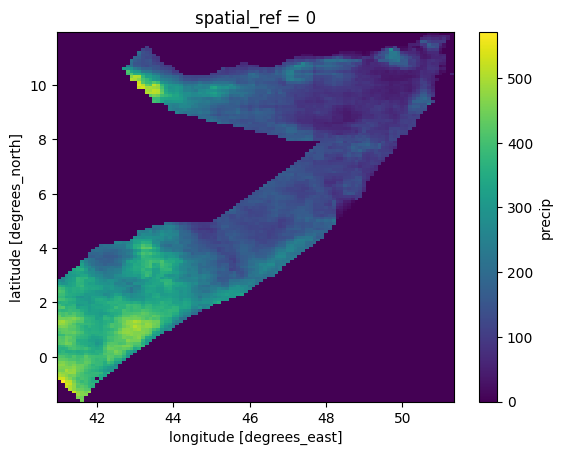

In [4]:
UC2_cube['precip'].sel(time='2016').sum(dim = ['time']).plot()

### 1.1 Aggregate Shapefiles



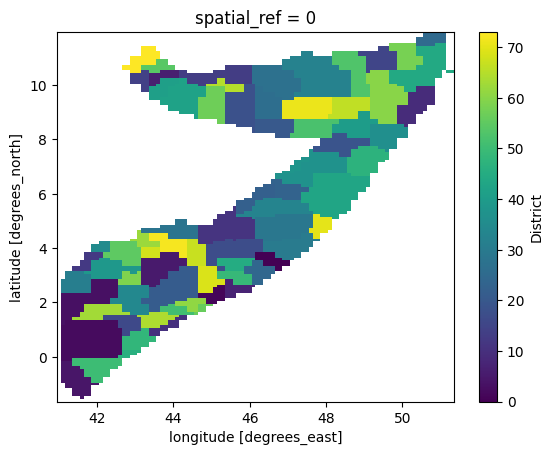

In [4]:
#%% Add district shapefile

Somalia_map_district["District"] = Somalia_map_district.admin2Name.index.astype(int)

district_geom = Somalia_map_district.to_crs(UC2_cube.rio.crs)

# From geopandas to xarray
district_geom = make_geocube(vector_data=Somalia_map_district, resolution=(0.1, -0.1), fill=np.NaN)

district_geom = district_geom.rename({'y': 'latitude', 'x': 'longitude'})

district_geom = district_geom.interp(latitude=UC2_cube.latitude, longitude=UC2_cube.longitude, method='nearest')

# Assign the district names as an attribute to the "district" variable
district_geom['District'].attrs['District_Name'] = Somalia_map_district.admin2Name.to_list()

# Merge by lat/lon
UC2_cube = xr.merge([district_geom, UC2_cube])

UC2_cube.District.plot()


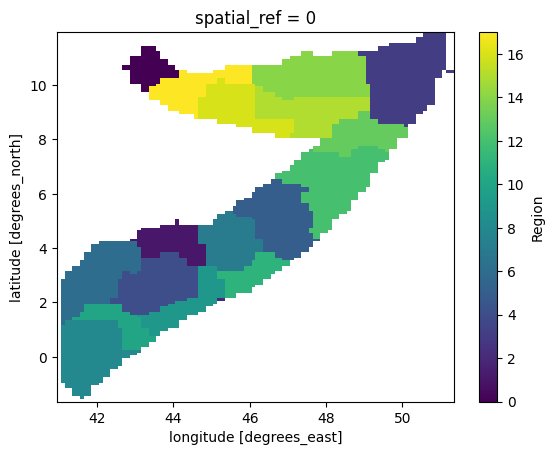

In [5]:
#%% Add Region shapefile

Somalia_map_region["Region"] = Somalia_map_region.ADM1_EN.index.astype(int)

region_geom = Somalia_map_region.to_crs(UC2_cube.rio.crs)

# From geopandas to xarray
region_geom = make_geocube(vector_data=Somalia_map_region, resolution=(0.1, -0.1), fill=np.NaN)

region_geom = region_geom.rename({'y': 'latitude', 'x': 'longitude'})

region_geom = region_geom.interp(latitude=UC2_cube.latitude, longitude=UC2_cube.longitude,  method='nearest')

# Assign the district names as an attribute to the "district" variable
region_geom['Region'].attrs['Region_Name'] = Somalia_map_region.ADM1_EN.to_list()

# Merge by lat/lon
UC2_cube = xr.merge([region_geom, UC2_cube])

UC2_cube.Region.plot()


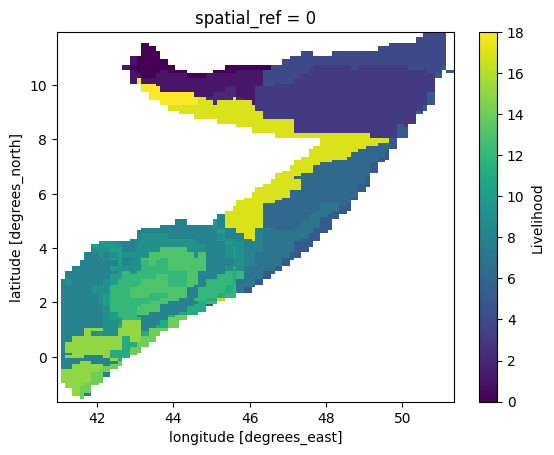

In [6]:
#%% Add Livelihood Zone Shapefile

Somalia_map_livelihood["Livelihood"] = Somalia_map_livelihood.LZNAMEEN.index.astype(int)

livel_geom = Somalia_map_livelihood.to_crs(UC2_cube.rio.crs)

# From geopandas to xarray
livel_geom = make_geocube(vector_data=Somalia_map_livelihood, resolution=(0.1, -0.1), fill=np.NaN)

livel_geom = livel_geom.rename({'y': 'latitude', 'x': 'longitude'})

livel_geom = livel_geom.interp(latitude=UC2_cube.latitude, longitude=UC2_cube.longitude,  method='nearest')

# Assign the district names as an attribute to the "district" variable
livel_geom['Livelihood'].attrs['Livelihood_Name'] = Somalia_map_livelihood.LZNAMEEN.to_list()

# Merge by lat/lon
UC2_cube = xr.merge([livel_geom, UC2_cube])

UC2_cube.Livelihood.plot()

# 2. Socioeconomic Cube

### 2.1 Conflict Cube

In [27]:
#%% Download ACLED datasets

def fetch_ACLED_data():

    key = 'upUDWqNGHqRnz4ZDD8mY'
    email = 'jomataha@uv.es'

    params = {
                    "key": key,
                    "email": email,
                    "first_event_date": '2006-01-01',
                    "last_event_date": str(date.today()),
                    "limit":100000000000000, # No limit
                    "country": 'Somalia',
                }

    res = requests.get("https://api.acleddata.com/acled/read", params=params)
    data_json = res.json()['data']
    ACLED_df = pd.json_normalize(data_json)

    print('ACLED data retreived succesfully')
    
    ACLED_df.to_csv('ACLED_df.csv', index  = False)

    return ACLED_df

ACLED_df = fetch_ACLED_data()

ACLED data retreived succesfully


In [44]:
#%% Build Conflict Cube

ACLED_df = pd.read_csv('ACLED_df.csv')

# Clean and format conflict data
ACLED_df = ACLED_df[['fatalities', 'event_date', 'longitude', 'latitude']].rename(columns={'event_date':'time'})

ACLED_df.time = pd.to_datetime(ACLED_df.time)

ACLED_df = ACLED_df[(ACLED_df['time'].dt.year >= 2010)].sort_values('time')


# Here we take ACLED data and regridd them to era5 resolution: we do it by year to avoid memory allocation issues
acled_xarray = []

# Define the bin edges for the desired coarser resolution
lat_bins = UC2_cube.latitude.values
lon_bins = UC2_cube.longitude.values

for year in ACLED_df['time'].dt.year.unique():

    acled_year = ACLED_df[(ACLED_df['time'].dt.year == year)]

    acled_year = acled_year.groupby(['time', 'longitude', 'latitude']).sum()

    # Tons of NaN but works when converting back
    acled_year_xarray = acled_year.to_xarray()

    acled_year_xarray.rio.write_crs(crs_projection, inplace=True)

    acled_year_xarray = acled_year_xarray.sortby(['time', 'latitude', 'longitude'])    

    # Perform the aggregation by grouping the fine resolution dataset into coarser bins
    regridded_ds = acled_year_xarray.groupby_bins('longitude', lon_bins, labels=lon_bins[:-1]).sum(dim='longitude')
    regridded_ds = regridded_ds.groupby_bins('latitude', lat_bins, labels=lat_bins[:-1]).sum(dim='latitude')
    regridded_ds = regridded_ds.rename({'longitude_bins': 'longitude', 'latitude_bins': 'latitude'})

    acled_xarray.append(regridded_ds)

# Join along time
acled_xarray = xr.concat(acled_xarray, dim='time')

# Join both cubes: 
UC2_cube = xr.merge([UC2_cube, acled_xarray])

UC2_cube

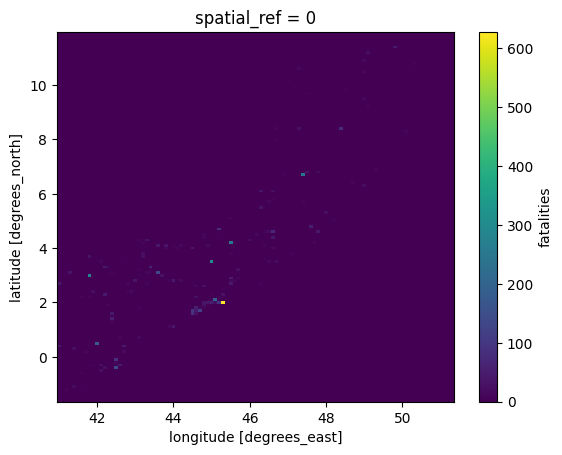

In [17]:
UC2_cube['fatalities'].sel(time='2016').sum(dim = ['time']).plot()

### 2.2 Displacement Cube

In [67]:
#%% Download PRMN datasets

def collect_PRMN_IDP(url):

    # Collect NEW DATA from PRMN website
    response = requests.get(url)
    if response.status_code == 200:
        data = requests.get(url).content
        PRMN_data = pd.read_excel(BytesIO(data), engine='openpyxl')
        print("PRMN file downloaded successfully.")
    else:
        print("Failed to download the PRMN file.")

    # Convert Year Week to DATE
    PRMN_data['Arrival'] = pd.to_datetime(PRMN_data['Year Week'].astype(str) + '-1', format='%Y%W-%w')

    # Select columns
    PRMN_data.rename(columns = {'Arrival': 'Date', 'Previous (Departure) District': 'District', 'Number of Individuals':'IDP','Previous (Departure) Region': 'Region'}, inplace = True)
    PRMN_data = PRMN_data[['Date', 'Region', 'District', 'Reason', 'IDP']]
    # Drought
    new_drought = PRMN_data[PRMN_data['Reason'] == 'Drought related'].drop('Reason', axis = 1)
    new_drought.rename(columns = {'IDP':'IDP_Drought'}, inplace = True)
    # Conflict
    new_conflict = PRMN_data[PRMN_data['Reason'] == 'Conflict/Insecurity'].drop('Reason', axis = 1)
    new_conflict.rename(columns = {'IDP':'IDP_Conflict'}, inplace = True)

    PRMN_data_IDP = pd.merge(new_drought, new_conflict, on=['Date', 'Region', 'District'], how='outer')

    PRMN_data_IDP.to_csv('PRMN_df.csv', index  = False)

    return PRMN_data_IDP

# Collect Data from github:
url = "https://unhcr.github.io/dataviz-somalia-prmn/data/UNHCR-PRMN-Displacement-Dataset.xlsx"

PRMN_data_IDP = collect_PRMN_IDP(url)


PRMN file downloaded successfully.


In [77]:
#%% Build Displacement Cube

PRMN_data_IDP = pd.read_csv('PRMN_df.csv')

# Clean District Names
PRMN_data_IDP.District = correct_districts(PRMN_data_IDP.District)
# Sum repeated index entries 
PRMN_data_IDP = PRMN_data_IDP[['Date','District', 'IDP_Drought', 'IDP_Conflict']].groupby(['Date', 'District']).sum()

PRMN_data_IDP = PRMN_data_IDP.reset_index().sort_values(['District', 'Date']).reset_index(drop=True).rename(columns={'Date':'time'})

PRMN_data_IDP.time = pd.to_datetime(PRMN_data_IDP.time)

PRMN_data_IDP = PRMN_data_IDP[PRMN_data_IDP['District'].isin(Somalia_map_district.admin2Name.unique())]

# Factorize district to join to cube
PRMN_data_IDP['District'], _ = pd.factorize(PRMN_data_IDP['District'])

PRMN_data_IDP

,time,District,IDP_Drought,IDP_Conflict
0,2016-02-22,0,4.0,0.0
1,2016-04-04,0,5.0,0.0
2,2016-05-02,0,0.0,10200.0
3,2016-06-06,0,0.0,222.0
4,2016-06-27,0,0.0,160.0
...,...,...,...,...
17483,2023-01-30,73,169.0,0.0
17484,2023-02-13,73,12.0,0.0
17485,2023-02-20,73,12.0,0.0
17486,2023-02-27,73,12.0,0.0


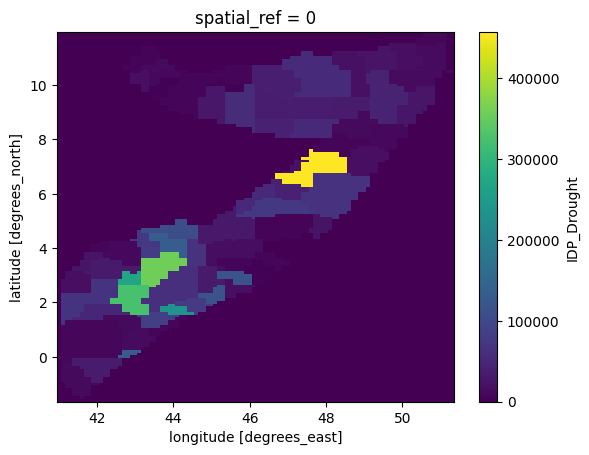

In [78]:
#%% Build displacement cube

# Extract lat_lon values from cube for each district
district_lat_lon = UC2_cube.District.to_dataframe().reset_index()[['latitude', 'longitude','District']]
# Join displacement values onto corresponding coordinates
IDP_xarray = district_lat_lon.merge(PRMN_data_IDP, on='District')

IDP_xarray = IDP_xarray.drop(columns='District').set_index(['latitude', 'longitude', 'time']).to_xarray()

# Add IDP xarray to cube
UC2_cube = xr.merge([UC2_cube, IDP_xarray])

UC2_cube['IDP_Drought'].sum(dim = ['time']).plot()


### 2.3 Market Cube

In [108]:
#%% Load and clean market price data

current_year = date.today().year
years = list(range(2010, current_year + 1))

market_data = pd.DataFrame()

for year in years:
    
    # OneDrive/Escritorio/Work_to_Do/Somalia 2nd Cycle/Models/Automate_Data_Collection/FSNAU MARKET DATA
    path = 'FSNAU MARKET DATA\FSNAU-Market-Data-' + str(year) + ".csv"
    market_year = pd.read_csv(path)
    market_data = pd.concat([market_data, market_year])

    
market_data = market_data.sort_values(by = ['Market', 'Year', 'Month']).reset_index(drop=True)
market_data = market_data.dropna(subset= ['Market', 'District', 'Region'])
market_data = market_data.replace('-', np.NaN)
market_data.iloc[:,6:] = market_data.iloc[:,6:].astype(float)

def entitle(string):
    return string.title()

market_data['Region'] = market_data['Region'].apply(entitle)
market_data['District'] = market_data['District'].apply(entitle)
market_data['Market'] = market_data['Market'].apply(entitle)

market_data['Date'] = pd.to_datetime(market_data['Year'].astype(str) + '-' + market_data['Month'])
print(market_data['Date'].max())
market_data['Date'] = market_data['Date'] + timedelta(15)
market_data = market_data.drop(columns = ['Month', 'Year'])

# Drop features that have few points.
# I drop 50kg vs 1kg because 1kg is better sampled
# I get local quality vs export quality because same dynamics and better sampled

# We sometimes have stepped prices that are constant throghout time (which does not make sense)
# For water we have nice looking prices for water drum and WaterOneJerican20litre independent of the district
# WheatMaize1kg reflects better peaks in drought periods than Flour

market_data.rename(columns = {'RedSorghum1kg': 'Red Sorghum Price', 'WheatFlour1kg': 'Wheat Flour Price', 'Cowpeas': 'Cowpeas Price',
                             'Sugar': 'Sugar Price', 'TeaLeaves': 'Tea Leaves Price', 'Salt': 'Salt Price', 'VegetableOil1litre': 'Vegetable Oil Price',
                             'GoatLocalQuality': 'Goat Price', 'CattleLocalQuality': 'Cattle Price', 'CamelLocalQuality': 'Camel Price',
                             'FreshCamelMilk1litre': 'Camel Milk Price', 'WaterDrum': 'Water Drum Price'}, inplace=True)


features = ['Red Sorghum Price', 'Wheat Flour Price', 'Sugar Price', 'Vegetable Oil Price', 'Camel Milk Price', 'Tea Leaves Price','Salt Price', 'Cowpeas Price', 
            'Water Drum Price', 'Cattle Price', 'Camel Price', 'Goat Price']

market_data = market_data[['Date', 'Region', 'District', 'Market']+features]

# Include all dates: 
t_index = pd.date_range(start='2009-12-31', end=market_data.Date.max(), freq='M')

def newindex(data):
    return data.reindex(t_index)

market_data = market_data.groupby(['Region','District','Market']).resample('M', label='left', closed = 'left', on='Date').mean().reset_index(level=['Region', 'District', 'Market']).groupby(['Region', 'District', 'Market']).apply(newindex)
market_data.index.names = ['Region', 'District', 'Market','Date']
market_data = market_data.reset_index(level = 'Date').reset_index(drop = True)

market_data[['Region','District','Market']] = market_data[['Region','District','Market']].fillna(method="ffill")

market_data.District = correct_districts(market_data.District)
market_data.Market = correct_districts(market_data.Market)
market_data.Region = correct_regions(market_data.Region)

market_data.head()


2023-04-01 00:00:00


,Date,Region,District,Market,Red Sorghum Price,Wheat Flour Price,Sugar Price,Vegetable Oil Price,Camel Milk Price,Tea Leaves Price,Salt Price,Cowpeas Price,Water Drum Price,Cattle Price,Camel Price,Goat Price
0,2009-12-31,Awdal,Borama,Borama,NaN,4462.5,5200.0,11500.0,5000.0,6000.0,2300.0,12000.0,2000.0,1280000.0,NaN,170000.0
1,2010-01-31,Awdal,Borama,Borama,2037.5,4500.0,5300.0,11500.0,5000.0,6000.0,2300.0,11500.0,2000.0,1400000.0,NaN,195000.0
2,2010-02-28,Awdal,Borama,Borama,2084.375,3750.9615,5442.3077,9461.5385,4000.0,11123.0769,2815.3846,9000.0,3153.8462,1047916.6667,932516.25,261057.6923
3,2010-03-31,Awdal,Borama,Borama,1850.0,3200.0,5200.0,9500.0,3500.0,9600.0,3000.0,8375.0,3000.0,1047916.6667,932516.25,222500.0
4,2010-04-30,Awdal,Borama,Borama,2500.0,3200.0,5200.0,9500.0,3000.0,9000.0,3000.0,7625.0,1000.0,700000.0,900000.0,350000.0


In [109]:
#%% Select the market with the best data quality for each commodity

def aggregate_best_market(market_dataframe):

    agg_level='District'
    # Prepare the search
    market_dataframe = market_dataframe.drop_duplicates(subset = ['Market', 'Date']).copy()

    # Ordinal Variance to select data quality
    ord_enc = OrdinalEncoder()

    final_dataframe = pd.DataFrame()
    for zone in np.unique(market_dataframe[agg_level]):    

        this_zone = market_dataframe[market_dataframe[agg_level] == zone].fillna(0)
        this_zone = this_zone[this_zone.Date >= '2010']
        zone_markets = np.unique(this_zone.Market)

        # For each district save the best feature column
        best_market_data = this_zone[this_zone['Market'] == zone_markets[0]][['Date', agg_level]].reset_index(drop=True)

        # print('Markets in ' + agg_level + ' = ', zone_markets)
        # print('-----------------------------------------------')

        # Iterate through the features:

        for feature in this_zone.columns[4:]:
            
            ord_variance = np.array([])

            # Iterate through markets
            for market in zone_markets:

                # Select market and ordinal encode values and then calculate variance
                check_market = this_zone[this_zone['Market'] == market]
                market_enc = ord_enc.fit_transform(np.array(check_market[feature]).reshape(-1, 1)).astype(int)
                variance = np.var(market_enc.flatten())

                # print(feature)
                # print(market)
                # print(this_zone[this_zone['Market'] == market]['Market Type'].iloc[0])
                # print('Ordinal Variance =', variance)

                ord_variance = np.append(ord_variance, variance)

            # Select the feature that has the maximum variance among markets
            max_index = np.argmax(ord_variance)
            market_best_feature = zone_markets[max_index]

            # print(market_best_feature)

            # Append the best feature to the district data
            best_market_feature = this_zone[(this_zone['Market'] == market_best_feature)][feature].reset_index(drop=True)
            best_market_data = pd.concat([best_market_data, best_market_feature], axis=1)

            # print('selected:', feature, 'in', market_best_feature, 'for:', zone)
            # print('-------------------------------------------------')

        # Concatenate district data to the final dataframe
        final_dataframe = pd.concat([final_dataframe, best_market_data], axis=0).reset_index(drop=True)

    final_dataframe = final_dataframe.replace(0, np.nan)
    
    return final_dataframe

market_data_best = aggregate_best_market(market_data)


In [110]:
#%% Create Market Cube

# Select the values in the "district" column that are present in the array
market_data_best = market_data_best[market_data_best['District'].isin(Somalia_map_district.admin2Name.unique())]

market_data_best = market_data_best.sort_values(['District', 'Date']).reset_index(drop=True).rename(columns={'Date':'time'}).drop_duplicates()

market_data_best['District'], _ = pd.factorize(market_data_best['District'])

# Extract lat lon from UC2_cube
district_lat_lon = UC2_cube.District.to_dataframe().reset_index()[['latitude', 'longitude','District']]

market_data_xarray = district_lat_lon.merge(market_data_best, on='District')

market_data_xarray = market_data_xarray.drop(columns='District').set_index(['latitude', 'longitude', 'time']).to_xarray()

# Add IDP xarray to cube
UC2_cube = xr.merge([UC2_cube, market_data_xarray])

In [33]:
UC2_cube

<xarray.Dataset>
Dimensions:              (latitude: 136, longitude: 104, time: 9798)
Coordinates:
  * latitude             (latitude) float32 -1.6 -1.5 -1.4 ... 11.7 11.8 11.9
  * longitude            (longitude) float32 41.0 41.1 41.2 ... 51.1 51.2 51.3
  * time                 (time) datetime64[ns] 2010-01-01 ... 2023-06-02
    spatial_ref          int32 0
Data variables: (12/27)
    Livelihood           (latitude, longitude) float64 nan nan nan ... nan nan
    Region               (latitude, longitude) float64 nan nan nan ... nan nan
    District             (latitude, longitude) float64 nan nan nan ... nan nan
    t2m                  (latitude, longitude, time) float32 nan nan ... nan nan
    pev                  (latitude, longitude, time) float32 nan nan ... nan nan
    tp                   (latitude, longitude, time) float32 nan nan ... nan nan
    ...                   ...
    Salt Price           (latitude, longitude, time) float64 nan nan ... nan nan
    Cowpeas Price        (latitude, longitude, time) float64 nan nan ... nan nan
    Water Drum Price     (latitude, longitude, time) float64 nan nan ... nan nan
    Cattle Price         (latitude, longitude, time) float64 nan nan ... nan nan
    Camel Price          (latitude, longitude, time) float64 nan nan ... nan nan
    Goat Price           (latitude, longitude, time) float64 nan nan ... nan nan

# Write Cube


In [34]:
vars_list = list(UC2_cube.data_vars)  
for var in vars_list:  
    if 'grid_mapping' in UC2_cube[var].attrs:
        del UC2_cube[var].attrs['grid_mapping']

UC2_cube.to_netcdf('UC2_cube.nc')

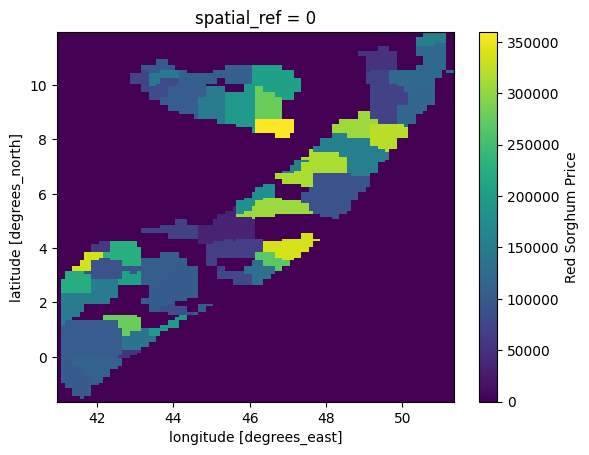

In [29]:
UC2_cube['Red Sorghum Price'].sel(time='2017').sum(dim = ['time']).plot()

# Check if everything is alright

In [128]:
UC2_cube = xr.open_dataset('UC2_cube.nc')

UC2_cube


<xarray.Dataset>
Dimensions:              (latitude: 136, longitude: 104, time: 9798)
Coordinates:
  * latitude             (latitude) float32 -1.6 -1.5 -1.4 ... 11.7 11.8 11.9
  * longitude            (longitude) float32 41.0 41.1 41.2 ... 51.1 51.2 51.3
  * time                 (time) datetime64[ns] 2010-01-01 ... 2023-06-02
Data variables: (12/28)
    Livelihood           (latitude, longitude) float64 ...
    spatial_ref          int32 ...
    Region               (latitude, longitude) float64 ...
    District             (latitude, longitude) float64 ...
    t2m                  (latitude, longitude, time) float32 ...
    pev                  (latitude, longitude, time) float32 ...
    ...                   ...
    Salt Price           (latitude, longitude, time) float64 ...
    Cowpeas Price        (latitude, longitude, time) float64 ...
    Water Drum Price     (latitude, longitude, time) float64 ...
    Cattle Price         (latitude, longitude, time) float64 ...
    Camel Price          (latitude, longitude, time) float64 ...
    Goat Price           (latitude, longitude, time) float64 ...

<Axes: xlabel='Date'>

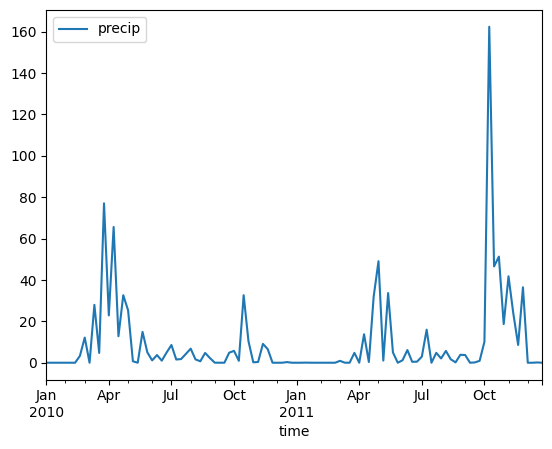

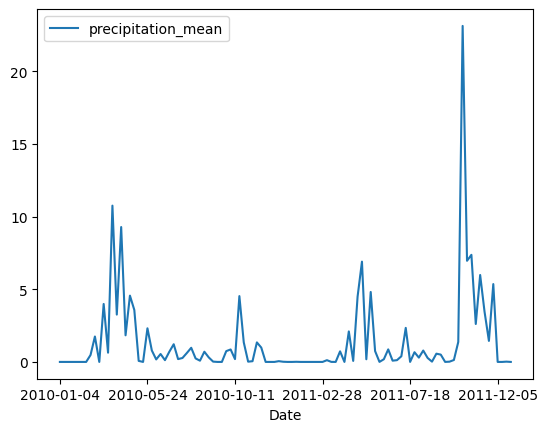

In [129]:
#%% Check aggregated CHIRPS in Baidoa: works

# Select Baidoa
filtered_data = UC2_cube.where(UC2_cube['District'] == 5, drop=True)

# spatial mean in the district
filtered_data = filtered_data.mean(dim=('latitude', 'longitude'))

# temporal sum:
filtered_data = filtered_data.precip.to_dataframe().reset_index().resample('W-MON', label='left', closed = 'left', on='time').sum().reset_index()

filtered_data['Year'] = pd.to_datetime(filtered_data['time']).dt.year

filtered_data[(filtered_data['Year'] == 2010) | (filtered_data['Year'] == 2011)].plot(x = 'time', y='precip')


#%% Check old CHIRPS
check_chirps = pd.read_csv('Somalia_District_Dataset_newMarket2.csv')

baidoa_chirps = check_chirps[['District', 'Date', 'precipitation_mean']][check_chirps.District == 'Baidoa']

# Assuming your DataFrame is called 'df' and the column is 'Date'
baidoa_chirps['Year'] = pd.to_datetime(baidoa_chirps['Date']).dt.year

# Filter the DataFrame for the year 2010
baidoa_chirps[(baidoa_chirps['Year'] == 2010) | (baidoa_chirps['Year'] == 2011)].plot(x = 'Date', y='precipitation_mean')


<Axes: xlabel='time'>

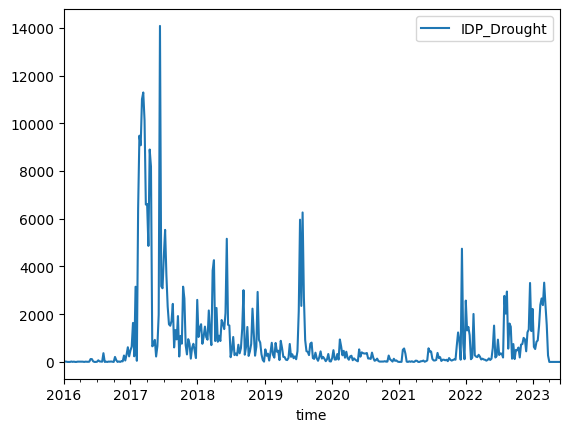

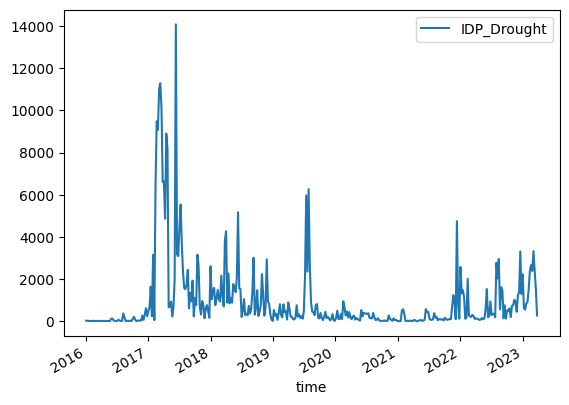

In [130]:
#%% Check aggregated IDP in Baidoa: works

# Select Baidoa (faster if we use a mask and the command .sel)
filtered_data = UC2_cube.where(UC2_cube['District'] == 5, drop=True)

# spatial mean in the district
filtered_data = filtered_data.mean(dim=('latitude', 'longitude'))

filtered_data = filtered_data['IDP_Drought'].to_dataframe().reset_index().resample('W-MON', label='left', closed = 'left', on='time').sum().reset_index()

filtered_data['Year'] = pd.to_datetime(filtered_data['time']).dt.year

filtered_data[(filtered_data['Year'] >= 2016)].plot(x = 'time', y='IDP_Drought')


#%% Check PRMN

baidoa_PRMN_data_IDP = PRMN_data_IDP[['District', 'time', 'IDP_Drought']][PRMN_data_IDP.District == 5]

# Assuming your DataFrame is called 'df' and the column is 'Date'
baidoa_PRMN_data_IDP['Year'] = pd.to_datetime(baidoa_PRMN_data_IDP['time']).dt.year

# Filter the DataFrame for the year 2010
baidoa_PRMN_data_IDP[(baidoa_PRMN_data_IDP['Year'] >= 2016)].fillna(0).plot(x = 'time', y='IDP_Drought')

<Axes: xlabel='time'>

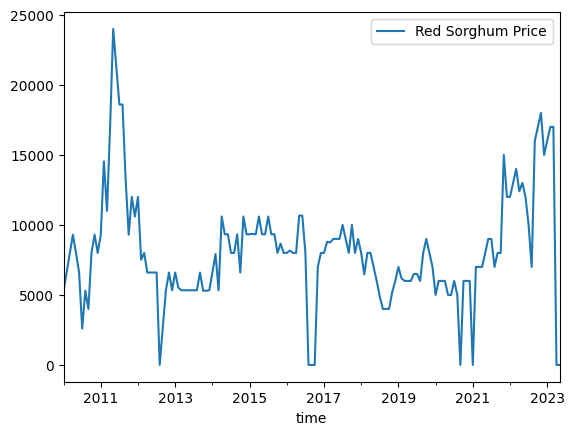

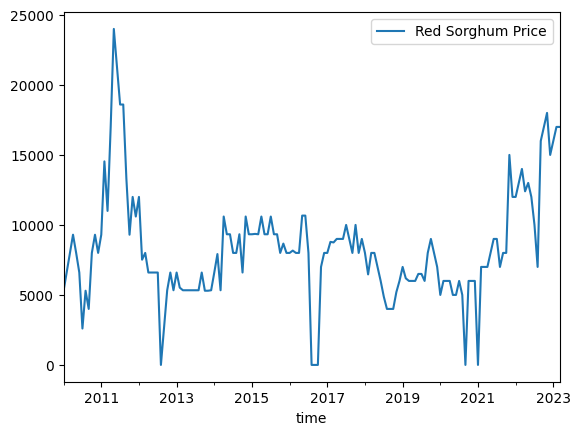

In [131]:
#%% Check Market in Baidoa: works

# Select Baidoa (faster if we use a mask and the command .sel)
filtered_data = UC2_cube.where(UC2_cube['District'] == 5, drop=True)

# spatial mean in the district
filtered_data = filtered_data.mean(dim=('latitude', 'longitude'))

filtered_data = filtered_data['Red Sorghum Price'].to_dataframe().reset_index().resample('M', label='left', closed = 'left', on='time').sum().reset_index()

filtered_data['Year'] = pd.to_datetime(filtered_data['time']).dt.year

filtered_data[(filtered_data['Year'] >= 2010)].interpolate().plot(x = 'time', y='Red Sorghum Price')

#%% Check FSNAU
baidoa_market_data_best = market_data_best[['District', 'time', 'Red Sorghum Price']][market_data_best.District == 5]

# Assuming your DataFrame is called 'df' and the column is 'Date'
baidoa_market_data_best['Year'] = pd.to_datetime(baidoa_market_data_best['time']).dt.year

# Filter the DataFrame for the year 2010
baidoa_market_data_best[(baidoa_market_data_best['Year'] >= 2010)].fillna(0).plot(x = 'time', y='Red Sorghum Price')


<Axes: xlabel='Date'>

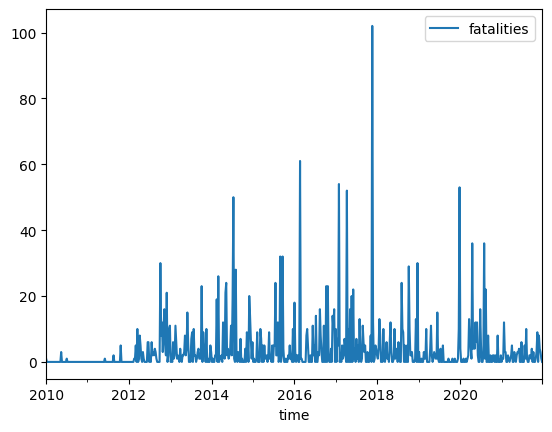

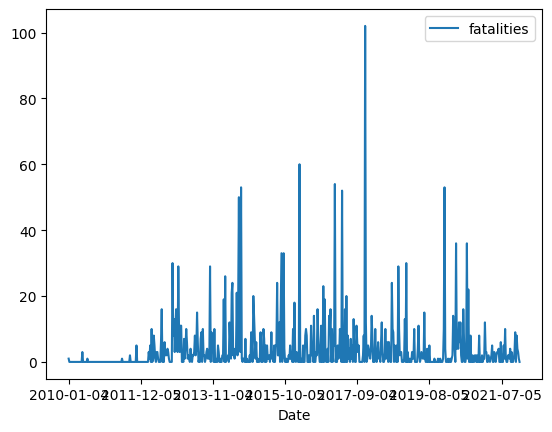

In [132]:
#%% Check aggregated ACLED in Baidoa: works

# Select Baidoa
filtered_data = UC2_cube.where(UC2_cube['District'] == 5, drop=True)

# spatial sum in the district
filtered_data = filtered_data.sum(dim=('latitude', 'longitude'))

# temporal sum:
filtered_data = filtered_data.fatalities.to_dataframe().reset_index().resample('W-MON', label='left', closed = 'left', on='time').sum().reset_index()

filtered_data['Year'] = pd.to_datetime(filtered_data['time']).dt.year

filtered_data[(filtered_data['Year'] >= 2010) & (filtered_data['Year'] < 2022)].fillna(0).plot(x = 'time', y='fatalities')


#%% Check old ACLED
check_acled = pd.read_csv('Somalia_District_Dataset_newMarket2.csv')

baidoa_acled = check_acled[['District', 'Date', 'fatalities']][check_acled.District == 'Baidoa']

# Assuming your DataFrame is called 'df' and the column is 'Date'
baidoa_acled['Year'] = pd.to_datetime(baidoa_acled['Date']).dt.year

# Filter the DataFrame for the year 2010
baidoa_acled[(baidoa_acled['Year'] >= 2010) & (baidoa_acled['Year'] < 2022)].fillna(0).plot(x = 'Date', y='fatalities')
